### 1.Processing Data

In [1]:
# Processing Data
import sys
sys.path.append('..')

from utilities import *

warnings.filterwarnings('ignore')

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

data = sa.data[sa.brand35]
data = data.drop(columns=['unit.sales'])

train_data, test_data = sa.divide_data_for_train_and_test(data)

/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Importing plotly failed. Interactive plots will not work.


### 2. Linear Regression

In [2]:
# Linear Regression
model, design_info, selected_columns = sa.modelization_with_backward_elimination(train_data)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           volume_sales   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     134.2
Date:                Sat, 20 Dec 2025   Prob (F-statistic):          4.22e-223
Time:                        23:39:45   Log-Likelihood:                -7343.0
No. Observations:                 644   AIC:                         1.473e+04
Df Residuals:                     620   BIC:                         1.484e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

### 3. Create exogenous variables

Diagnostic exogenous variables

In [3]:
X_train_exog = sa.x_train_exog(train_data, selected_columns, model)

In [5]:

print("=" * 60)
print("DIAGNÓSTICO DE VARIABLES EXÓGENAS")
print("=" * 60)

# 1. Información básica
print("\n1. INFORMACIÓN BÁSICA:")
print(f"   - Número de observaciones: {len(X_train_exog)}")
print(f"   - Número de variables exógenas: {len(X_train_exog.columns)}")
print("   - Nombres de variables exógenas:")
for col in X_train_exog.columns:
    print(f"     · {col}")

# 2. Valores faltantes
print("\n2. VALORES FALTANTES:")
missing = X_train_exog.isna().sum()
if missing.sum() > 0:
    print("   ⚠️  HAY VALORES FALTANTES:")
    print(missing[missing > 0])
else:
    print("   ✅ No hay valores faltantes")

# 3. Valores infinitos
print("\n3. VALORES INFINITOS:")
inf_values = np.isinf(X_train_exog).sum()
if inf_values.sum() > 0:
    print("   ⚠️  HAY VALORES INFINITOS:")
    print(inf_values[inf_values > 0])
else:
    print("   ✅ No hay valores infinitos")

# 4. Estadísticas descriptivas
print("\n4. ESTADÍSTICAS DESCRIPTIVAS:")
print(X_train_exog.describe())

# 5. Valores extremos (outliers)
print("\n5. DETECCIÓN DE VALORES EXTREMOS:")
Q1 = X_train_exog.quantile(0.25)
Q3 = X_train_exog.quantile(0.75)
IQR = Q3 - Q1
outliers = ((X_train_exog < (Q1 - 3 * IQR)) | (X_train_exog > (Q3 + 3 * IQR))).sum()
if outliers.sum() > 0:
    print("   ⚠️  Variables con valores extremos (>3*IQR):")
    print(outliers[outliers > 0])
else:
    print("   ✅ No se detectaron valores extremos significativos")

# 6. Rango de valores (escalas muy diferentes)
print("\n6. RANGOS DE VALORES (verificar escalas):")
ranges = X_train_exog.max() - X_train_exog.min()
print(ranges.sort_values(ascending=False))
print("\n   ⚠️  Si hay rangos muy diferentes, considera estandarizar las variables")

# 7. MATRIZ DE CORRELACIÓN (multicolinealidad)
print("\n7. ANÁLISIS DE MULTICOLINEALIDAD:")
corr_matrix = X_train_exog.corr()
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.95:  # Correlación muy alta
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr:
    print("   ⚠️  VARIABLES ALTAMENTE CORRELACIONADAS (|r| > 0.95):")
    for var1, var2, corr_val in high_corr:
        print(f"      {var1} <-> {var2}: {corr_val:.4f}")
else:
    print("   ✅ No se encontraron correlaciones extremadamente altas")

# 8. Número de condición (medida de multicolinealidad)
print("\n8. NÚMERO DE CONDICIÓN (multicolinealidad):")
try:
    X_matrix = X_train_exog.values
    # Añadir constante para el cálculo
    X_with_const = np.column_stack([np.ones(len(X_matrix)), X_matrix])
    cond_number = np.linalg.cond(X_with_const)
    print(f"   Número de condición: {cond_number:.2e}")
    if cond_number > 1e12:
        print("   ⚠️  MULTICOLINEALIDAD EXTREMA - Esto puede causar AIC infinito")
    elif cond_number > 1e8:
        print("   ⚠️  Multicolinealidad alta - Puede causar problemas numéricos")
    else:
        print("   ✅ Número de condición aceptable")
except Exception as e:
    print(f"   ❌ Error calculando número de condición: {e}")

# 9. Verificar si hay columnas constantes o casi constantes
print("\n9. VARIABLES CONSTANTES O CASI CONSTANTES:")
constant_vars = []
for col in X_train_exog.columns:
    if X_train_exog[col].nunique() <= 1:
        constant_vars.append(col)
    elif X_train_exog[col].std() < 1e-10:
        constant_vars.append(col)

if constant_vars:
    print("   ⚠️  VARIABLES CONSTANTES O CASI CONSTANTES:")
    for var in constant_vars:
        print(f"      {var}: std={X_train_exog[var].std():.2e}, unique={X_train_exog[var].nunique()}")
else:
    print("   ✅ No hay variables constantes")

# 10. Verificar dimensiones con la variable dependiente
print("\n10. COMPATIBILIDAD CON VARIABLE DEPENDIENTE:")
print(f"   - Longitud de y (volume.sales): {len(train_data['volume.sales'])}")
print(f"   - Longitud de X_train_exog: {len(X_train_exog)}")
if len(train_data['volume.sales']) != len(X_train_exog):
    print("   ⚠️  DIMENSIONES NO COINCIDEN - Esto causará errores")
else:
    print("   ✅ Las dimensiones coinciden")

print("\n" + "=" * 60)
print("FIN DEL DIAGNÓSTICO")
print("=" * 60)

DIAGNÓSTICO DE VARIABLES EXÓGENAS

1. INFORMACIÓN BÁSICA:
   - Número de observaciones: 644
   - Número de variables exógenas: 27
   - Nombres de variables exógenas:
     · C(supermarket)[T.supermarket-B]
     · C(supermarket)[T.supermarket-D]
     · C(variant)[T.standard]
     · C(variant)[T.vegan]
     · C(pack_size)[T.351 - 500 GR]
     · C(pack_size)[T.501 - 700 GR]
     · C(pack_size)[T.701 - 1000 GR]
     · C(supermarket)[T.supermarket-B]:C(variant)[T.light]
     · C(supermarket)[T.supermarket-C]:C(variant)[T.light]
     · C(supermarket)[T.supermarket-B]:C(variant)[T.standard]
     · C(supermarket)[T.supermarket-C]:C(variant)[T.standard]
     · C(supermarket)[T.supermarket-D]:C(variant)[T.standard]
     · C(supermarket)[T.supermarket-B]:C(variant)[T.vegan]
     · C(supermarket)[T.supermarket-C]:C(pack_size)[T.351 - 500 GR]
     · C(supermarket)[T.supermarket-D]:C(pack_size)[T.351 - 500 GR]
     · C(supermarket)[T.supermarket-D]:C(pack_size)[T.501 - 700 GR]
     · C(supermarket)[T

Delete Problem Variables

In [6]:
# ========== SOLUCIÓN: ELIMINAR VARIABLES PROBLEMÁTICAS ==========

print("=" * 60)
print("SOLUCIÓN: LIMPIEZA DE VARIABLES EXÓGENAS")
print("=" * 60)

# Crear una copia para trabajar
X_train_exog_clean = X_train_exog.copy()

# 1. Identificar y eliminar variables constantes (rango = 0)
print("\n1. ELIMINANDO VARIABLES CONSTANTES:")
ranges = X_train_exog_clean.max() - X_train_exog_clean.min()
constant_vars = ranges[ranges == 0].index.tolist()
if constant_vars:
    print(f"   Eliminando {len(constant_vars)} variables constantes:")
    for var in constant_vars:
        print(f"     - {var}")
    X_train_exog_clean = X_train_exog_clean.drop(columns=constant_vars)
else:
    print("   ✅ No hay variables constantes")

# 2. Identificar y eliminar variables con correlación perfecta (|r| = 1.0)
print("\n2. ELIMINANDO VARIABLES CON CORRELACIÓN PERFECTA:")
corr_matrix = X_train_exog_clean.corr()
perfect_corr_pairs = []
vars_to_remove = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= 1.0 - 1e-10:  # Correlación perfecta (con tolerancia numérica)
            var1 = corr_matrix.columns[i]
            var2 = corr_matrix.columns[j]
            perfect_corr_pairs.append((var1, var2, corr_matrix.iloc[i, j]))
            # Eliminar la segunda variable (mantener la primera)
            if var2 not in vars_to_remove:
                vars_to_remove.add(var2)

if vars_to_remove:
    print(f"   Eliminando {len(vars_to_remove)} variables con correlación perfecta:")
    for var in vars_to_remove:
        print(f"     - {var}")
    X_train_exog_clean = X_train_exog_clean.drop(columns=list(vars_to_remove))
else:
    print("   ✅ No hay variables con correlación perfecta")

# 3. Limpieza adicional: eliminar variables altamente correlacionadas (|r| > 0.95)
# Esto ayuda a reducir aún más la multicolinealidad
print("\n3. ELIMINANDO VARIABLES ALTAMENTE CORRELACIONADAS (|r| > 0.95):")
corr_matrix = X_train_exog_clean.corr()
high_corr_vars = set()
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            var1 = corr_matrix.columns[i]
            var2 = corr_matrix.columns[j]
            high_corr_pairs.append((var1, var2, corr_matrix.iloc[i, j]))
            # Eliminar la segunda variable (mantener la primera)
            if var2 not in high_corr_vars:
                high_corr_vars.add(var2)

if high_corr_vars:
    print(f"   Eliminando {len(high_corr_vars)} variables altamente correlacionadas:")
    for var in high_corr_vars:
        print(f"     - {var}")
    X_train_exog_clean = X_train_exog_clean.drop(columns=list(high_corr_vars))
else:
    print("   ✅ No hay variables altamente correlacionadas")

# 4. Verificar número de condición después de la limpieza
print("\n4. VERIFICANDO NÚMERO DE CONDICIÓN DESPUÉS DE LA LIMPIEZA:")
try:
    X_matrix_clean = X_train_exog_clean.values
    X_with_const_clean = np.column_stack([np.ones(len(X_matrix_clean)), X_matrix_clean])
    cond_number_clean = np.linalg.cond(X_with_const_clean)
    print(f"   Número de condición original: 7.48e+17")
    print(f"   Número de condición después de limpieza: {cond_number_clean:.2e}")
    
    if cond_number_clean > 1e12:
        print("   ⚠️  AÚN HAY MULTICOLINEALIDAD EXTREMA")
        print("   💡 Considera eliminar más variables o usar regularización")
    elif cond_number_clean > 1e8:
        print("   ⚠️  Multicolinealidad alta - Puede causar problemas numéricos")
        print("   💡 El modelo puede funcionar, pero algunos ajustes pueden fallar")
    elif cond_number_clean > 1e6:
        print("   ⚠️  Multicolinealidad moderada - Generalmente aceptable")
    else:
        print("   ✅ Número de condición mejorado significativamente")
except Exception as e:
    print(f"   ❌ Error: {e}")

# 5. Resumen final
print("\n5. RESUMEN:")
print(f"   - Variables originales: {len(X_train_exog.columns)}")
print(f"   - Variables después de limpieza: {len(X_train_exog_clean.columns)}")
print(f"   - Variables eliminadas: {len(X_train_exog.columns) - len(X_train_exog_clean.columns)}")
print(f"   - Reducción: {((len(X_train_exog.columns) - len(X_train_exog_clean.columns)) / len(X_train_exog.columns) * 100):.1f}%")

print("\n" + "=" * 60)
print("VARIABLES LIMPIAS LISTAS PARA USAR")
print("=" * 60)
print("\n💡 Usa 'X_train_exog_clean' en lugar de 'X_train_exog' para auto_arima")


SOLUCIÓN: LIMPIEZA DE VARIABLES EXÓGENAS

1. ELIMINANDO VARIABLES CONSTANTES:
   Eliminando 1 variables constantes:
     - C(variant)[T.vegan]:C(pack_size)[T.351 - 500 GR]

2. ELIMINANDO VARIABLES CON CORRELACIÓN PERFECTA:
   Eliminando 2 variables con correlación perfecta:
     - C(supermarket)[T.supermarket-D]:C(pack_size)[T.501 - 700 GR]
     - C(variant)[T.light]:C(pack_size)[T.501 - 700 GR]

3. ELIMINANDO VARIABLES ALTAMENTE CORRELACIONADAS (|r| > 0.95):
   Eliminando 3 variables altamente correlacionadas:
     - price:C(supermarket)[T.supermarket-D]
     - price:C(variant)[T.vegan]
     - price:C(pack_size)[T.701 - 1000 GR]

4. VERIFICANDO NÚMERO DE CONDICIÓN DESPUÉS DE LA LIMPIEZA:
   Número de condición original: 7.48e+17
   Número de condición después de limpieza: 2.89e+15
   ⚠️  AÚN HAY MULTICOLINEALIDAD EXTREMA
   💡 Considera eliminar más variables o usar regularización

5. RESUMEN:
   - Variables originales: 27
   - Variables después de limpieza: 21
   - Variables eliminada

Correlation Matrix

VISUALIZACIÓN: MATRIZ DE CORRELACIÓN


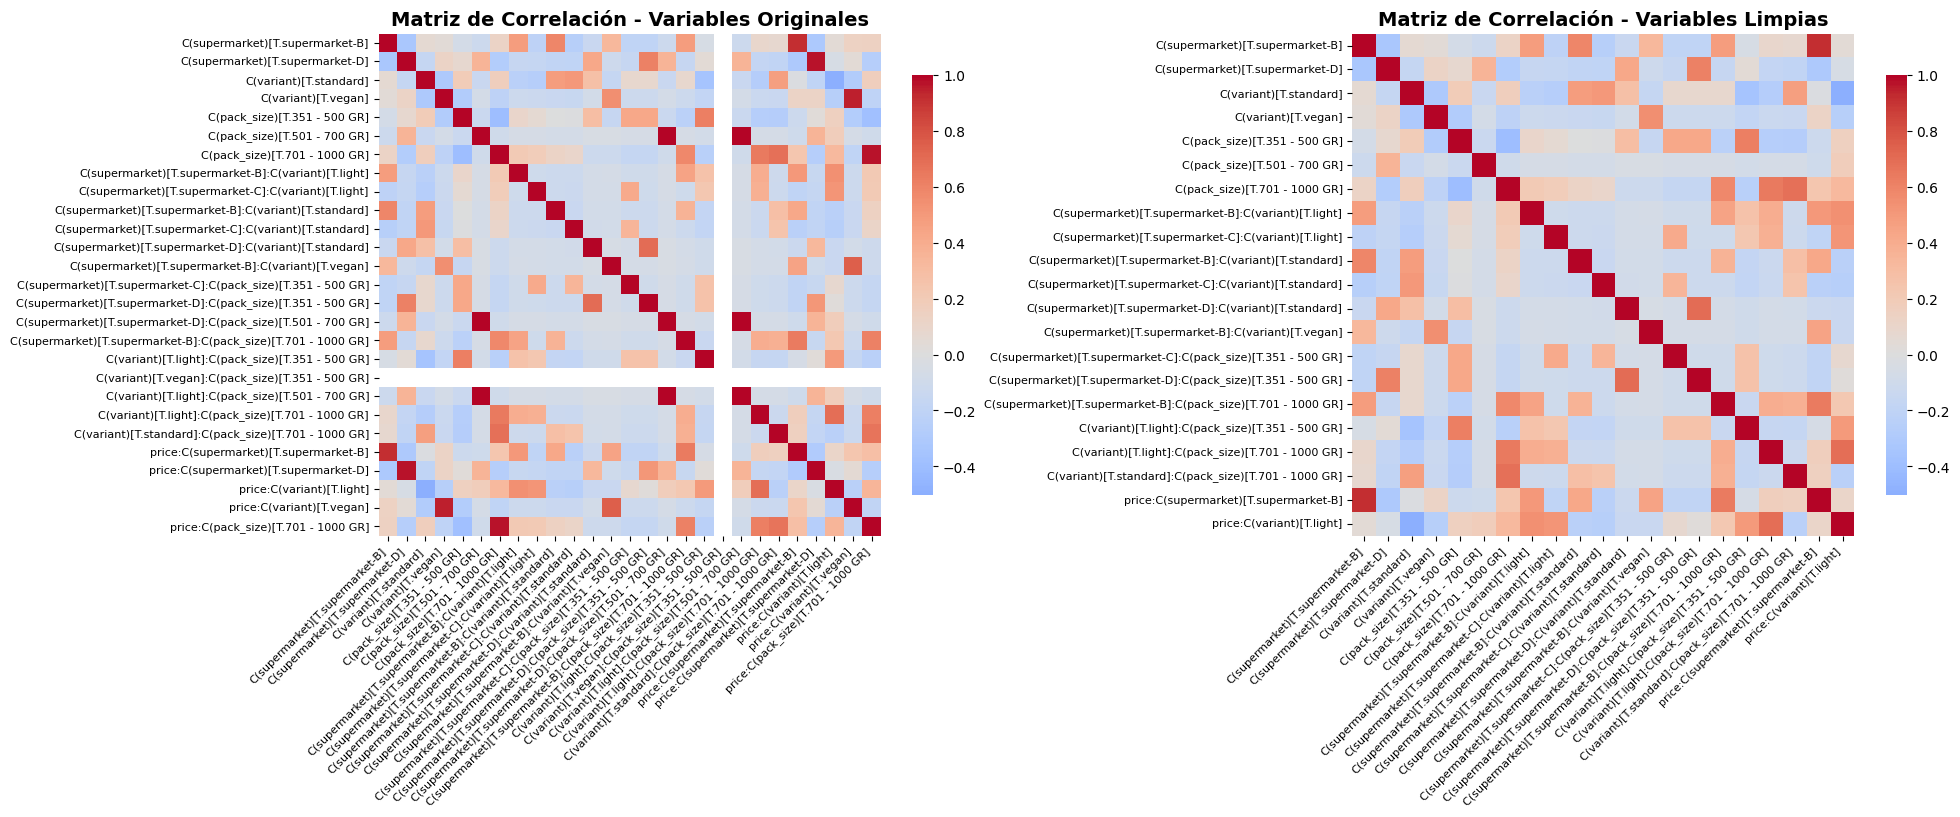


📊 ESTADÍSTICAS DE CORRELACIÓN:
   Original: 27 variables
   Limpias: 21 variables

   Correlaciones altas (|r| > 0.9) en original: 6
   Correlaciones altas (|r| > 0.9) en limpias: 1


In [7]:
# ========== VISUALIZACIÓN: MATRIZ DE CORRELACIÓN ==========

import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 60)
print("VISUALIZACIÓN: MATRIZ DE CORRELACIÓN")
print("=" * 60)

# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Matriz de correlación original
corr_original = X_train_exog.corr()
sns.heatmap(corr_original, annot=False, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Matriz de Correlación - Variables Originales', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=8)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, fontsize=8)

# Matriz de correlación después de limpieza
corr_clean = X_train_exog_clean.corr()
sns.heatmap(corr_clean, annot=False, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={"shrink": 0.8}, ax=axes[1])
axes[1].set_title('Matriz de Correlación - Variables Limpias', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=8)
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, fontsize=8)

plt.tight_layout()
plt.show()

# Estadísticas de correlación
print("\n📊 ESTADÍSTICAS DE CORRELACIÓN:")
print(f"   Original: {len(corr_original)} variables")
print(f"   Limpias: {len(corr_clean)} variables")
print(f"\n   Correlaciones altas (|r| > 0.9) en original: {((abs(corr_original) > 0.9).sum().sum() - len(corr_original)) // 2}")
print(f"   Correlaciones altas (|r| > 0.9) en limpias: {((abs(corr_clean) > 0.9).sum().sum() - len(corr_clean)) // 2}")


In [ ]:
print("=" * 60)
print("PROBANDO AUTO_ARIMA CON VARIABLES LIMPIAS")
print("=" * 60)

auto_arima_model_clean = auto_arima( 
    y=train_data['volume.sales'],
    X=X_train_exog_clean,  # Usar las variables limpias
    start_p=0,
    d=0,  
    start_q=0,
    max_p=3,  # Puedes aumentar esto si quieres probar más modelos
    max_q=3,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=1, 
    max_Q=1,
    m=12,
    seasonal=True,
    trace=True,
    error_action="warn",
    suppress_warnings=True,
    stepwise=True,  # Usar stepwise=True para ser más eficiente
    n_fits=50,  # Número de ajustes a probar
    information_criterion='aic'
)
    
   

PROBANDO AUTO_ARIMA CON VARIABLES LIMPIAS
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=14917.986, Time=0.41 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=14795.345, Time=10.32 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=16.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=18360.693, Time=0.30 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=14919.841, Time=0.26 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=21.59 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=146.50 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=14794.161, Time=4.54 sec


### 4. Analysing Resids 

In [ ]:
from scipy import stats
# Análisis de residuos

residuals = auto_arima_model_clean.arima_res_.resid

print("-----------------Residues Analysis (White Noise) -----------------")
sa.residual_white_noise_test(residuals)
print("------------------------------------------------------------------") 

# ========== GRÁFICO DE DIAGNÓSTICO DE RESIDUOS ==========

# Obtener residuos y valores ajustados
residuals = auto_arima_model_clean.arima_res_.resid
fitted_values = auto_arima_model_clean.arima_res_.fittedvalues

# Crear figura con 6 subplots (3 filas x 2 columnas)
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Análisis de Residuos - Diagnóstico del Modelo ARIMAX', fontsize=16, fontweight='bold')

# 1. Residuos vs. Tiempo (arriba-izquierda)
axes[0, 0].plot(residuals, color='blue', linewidth=0.8)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('Residuos vs. Tiempo', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Index')
axes[0, 0].set_ylabel('Residuos')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuos vs. Valores Ajustados (arriba-derecha)
axes[0, 1].scatter(fitted_values, residuals, alpha=0.5, s=10, color='blue')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 1].set_title('Residuos vs. Valores Ajustados', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Fitted Values')
axes[0, 1].set_ylabel('Residuos')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot (medio-izquierda)
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normalidad)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. ACF (Autocorrelación) (medio-derecha)
plot_acf(residuals, lags=12, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('Autocorrelación (ACF)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# 5. PACF (Autocorrelación Parcial) (abajo-izquierda)
plot_pacf(residuals, lags=12, ax=axes[2, 0], alpha=0.05, method='ywm')
axes[2, 0].set_title('Autocorrelación Parcial (PACF)', fontsize=12, fontweight='bold')
axes[2, 0].grid(True, alpha=0.3)

# 6. Histograma de Residuos (abajo-derecha)
axes[2, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[2, 1].set_title('Histograma de Residuos', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Residuos')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
 #TODO: revisar resultado para ver que no hay outliers muy grandes.
# Percentil 99
umbral_p99 = residuals.abs().quantile(0.99)

outliers_p99 = residuals[residuals.abs() > umbral_p99]

print(f"Residuales por encima del 99%: {len(outliers_p99)}")
# print data from outliers_p99
print(outliers_p99)
print(outliers_p99.describe())


## Forecasting begins

In [ ]:
# ========== PREPARAR VARIABLES EXÓGENAS DE TEST ==========

print("=" * 60)
print("PREPARACIÓN DE VARIABLES EXÓGENAS PARA TEST")
print("=" * 60)

# Preparar variables exógenas de test usando la misma transformación que en train
X_test_exog = sa.x_test_exog(test_data, selected_columns, design_info)

print(f"\n✅ Variables exógenas de test preparadas:")
print(f"   - Número de observaciones: {len(X_test_exog)}")
print(f"   - Número de variables exógenas: {len(X_test_exog.columns)}")
print(f"   - Columnas: {list(X_test_exog.columns)}")

# Verificar dimensiones
print(f"\n📊 Verificación de dimensiones:")
print(f"   - Train data length: {len(train_data)}")
print(f"   - Test data length: {len(test_data)}")
print(f"   - X_train_exog original: {len(X_train_exog)} observaciones, {len(X_train_exog.columns)} variables")
print(f"   - X_test_exog: {len(X_test_exog)} observaciones, {len(X_test_exog.columns)} variables")


In [ ]:
# ========== LIMPIAR VARIABLES EXÓGENAS DE TEST ==========

print("=" * 60)
print("LIMPIEZA DE VARIABLES EXÓGENAS DE TEST")
print("=" * 60)

# Limpiar variables exógenas de test usando la misma función
X_test_exog_clean_temp, removed_test, cond_before_test, cond_after_test = sa.clean_exogenous_variables(
    X_test_exog, corr_threshold=0.95, verbose=True
)

# IMPORTANTE: Filtrar columnas para que coincidan exactamente con las de train
# Solo mantener las columnas que están en X_train_exog_clean
train_columns = set(X_train_exog_clean.columns)
test_columns_available = set(X_test_exog_clean_temp.columns)

# Columnas que están en train pero no en test (después de limpieza)
missing_in_test = train_columns - test_columns_available
# Columnas que están en test pero no en train
extra_in_test = test_columns_available - train_columns

print(f"\n🔍 Análisis de compatibilidad de columnas:")
print(f"   - Columnas en train (limpias): {len(train_columns)}")
print(f"   - Columnas en test (después de limpieza): {len(test_columns_available)}")
if missing_in_test:
    print(f"   ⚠️  Columnas en train pero NO en test: {len(missing_in_test)}")
    for col in sorted(missing_in_test):
        print(f"      · {col}")
if extra_in_test:
    print(f"   ⚠️  Columnas en test pero NO en train: {len(extra_in_test)}")
    for col in sorted(extra_in_test):
        print(f"      · {col}")

# Asegurar que X_test_exog_clean tenga EXACTAMENTE las mismas columnas que X_train_exog_clean
# En el mismo orden y con las columnas faltantes rellenadas con ceros
X_test_exog_clean = pd.DataFrame(index=X_test_exog_clean_temp.index)

# Para cada columna en train, agregarla desde test (si existe) o con ceros (si no existe)
for col in X_train_exog_clean.columns:
    if col in X_test_exog_clean_temp.columns:
        # La columna existe en test, usar sus valores
        X_test_exog_clean[col] = X_test_exog_clean_temp[col]
    else:
        # La columna NO existe en test, agregarla con ceros
        X_test_exog_clean[col] = 0.0
        print(f"   ⚠️  Columna '{col}' no encontrada en test, se agregará con valores 0")

# Asegurar que las columnas estén en el mismo orden que en train
X_test_exog_clean = X_test_exog_clean[X_train_exog_clean.columns]

# Verificar que las columnas coincidan
if list(X_test_exog_clean.columns) == list(X_train_exog_clean.columns):
    print(f"\n✅ Columnas de test coinciden PERFECTAMENTE con train")
    print(f"   - Columnas finales: {len(X_test_exog_clean.columns)}")
    print(f"   - Columnas agregadas con ceros: {len(missing_in_test)}")
else:
    print(f"\n⚠️  ALERTA: Las columnas NO coinciden completamente")
    print(f"   - Columnas en train: {list(X_train_exog_clean.columns)}")
    print(f"   - Columnas en test: {list(X_test_exog_clean.columns)}")

print(f"\n📊 Resumen final:")
print(f"   - Variables exógenas de test (limpias y filtradas): {len(X_test_exog_clean.columns)}")
print(f"   - Observaciones de test: {len(X_test_exog_clean)}")


In [ ]:
# ========== VERIFICAR COMPATIBILIDAD FINAL ==========

print("=" * 60)
print("VERIFICACIÓN FINAL DE COMPATIBILIDAD")
print("=" * 60)

# Verificar que no haya valores faltantes o infinitos
print("\n1. VALORES FALTANTES E INFINITOS:")
missing_test = X_test_exog_clean.isna().sum().sum()
inf_test = np.isinf(X_test_exog_clean).sum().sum()

if missing_test > 0:
    print(f"   ⚠️  HAY {missing_test} VALORES FALTANTES en X_test_exog_clean")
    print(X_test_exog_clean.isna().sum()[X_test_exog_clean.isna().sum() > 0])
else:
    print(f"   ✅ No hay valores faltantes")

if inf_test > 0:
    print(f"   ⚠️  HAY {inf_test} VALORES INFINITOS en X_test_exog_clean")
else:
    print(f"   ✅ No hay valores infinitos")

# Verificar que las dimensiones sean correctas
print("\n2. DIMENSIONES:")
print(f"   - X_train_exog_clean: {X_train_exog_clean.shape}")
print(f"   - X_test_exog_clean: {X_test_exog_clean.shape}")
print(f"   - test_data['volume.sales']: {test_data['volume.sales'].shape}")

if len(test_data['volume.sales']) != len(X_test_exog_clean):
    print(f"   ⚠️  ALERTA: Las dimensiones NO coinciden")
else:
    print(f"   ✅ Las dimensiones coinciden")

# Verificar que las columnas sean idénticas
print("\n3. COLUMNAS:")
train_cols = set(X_train_exog_clean.columns)
test_cols = set(X_test_exog_clean.columns)

if train_cols == test_cols:
    print(f"   ✅ Las columnas son IDÉNTICAS")
    print(f"   - Número de columnas: {len(train_cols)}")
else:
    print(f"   ⚠️  Las columnas NO son idénticas")
    print(f"   - Diferencia: {train_cols.symmetric_difference(test_cols)}")

print("\n" + "=" * 60)
print("LISTO PARA HACER PREDICCIONES")
print("=" * 60)


In [ ]:
# ========== REALIZAR PREDICCIONES ==========

print("=" * 60)
print("PREDICCIONES CON MODELO GLOBAL ARIMAX")
print("=" * 60)

print(f"\n📊 Información del modelo:")
print(f"   - Orden ARIMA: {auto_arima_model_clean.order}")
print(f"   - Orden estacional: {auto_arima_model_clean.seasonal_order}")
print(f"   - AIC: {auto_arima_model_clean.aic():.2f}")
print(f"   - Variables exógenas: {len(X_train_exog_clean.columns)}")
print(f"   - Pasos a predecir: {len(test_data)}")

print("\n⏳ Realizando predicciones...")

try:
    # Obtener el modelo statsmodels subyacente
    arima_res = auto_arima_model_clean.arima_res_
    
    # Hacer predicciones con intervalos de confianza
    forecast = arima_res.get_forecast(steps=len(test_data), exog=X_test_exog_clean)

    # Extraer predicciones punto
    predictions = forecast.predicted_mean
    
    # Extraer intervalos de confianza (opcional)
    conf_int = forecast.conf_int()
    
    print("✅ Predicciones realizadas exitosamente")
    print(f"\n📈 Resumen de predicciones:")
    print(f"   - Número de predicciones: {len(predictions)}")
    print(f"   - Media de predicciones: {predictions.mean():.2f}")
    print(f"   - Desviación estándar: {predictions.std():.2f}")
    print(f"   - Mínimo: {predictions.min():.2f}")
    print(f"   - Máximo: {predictions.max():.2f}")
    
    # Comparar con valores reales
    actual_values = test_data['volume.sales'].values
    print(f"\n📊 Comparación con valores reales:")
    print(f"   - Media real: {actual_values.mean():.2f}")
    print(f"   - Media predicha: {predictions.mean():.2f}")
    print(f"   - Diferencia: {abs(actual_values.mean() - predictions.mean()):.2f}")
    
except Exception as e:
    print(f"\n❌ Error al realizar predicciones: {e}")
    import traceback
    traceback.print_exc()


In [ ]:
# ========== TABLA DE PREDICCIONES ==========

print("=" * 60)
print("TABLA DE PREDICCIONES")
print("=" * 60)

# Verificar que las predicciones se hayan realizado correctamente
if 'predictions' not in locals() or predictions is None:
    print("❌ Error: Las predicciones no se realizaron correctamente.")
    print("   Por favor, ejecuta primero la celda anterior de predicciones.")
else:
    # Preparar datos para la tabla
    fecha_col = test_data.index if hasattr(test_data.index, 'strftime') else range(len(test_data))
    if hasattr(test_data.index, 'strftime'):
        try:
            fecha_col = test_data.index
        except:
            fecha_col = range(len(test_data))
    
    # Crear diccionario base para el DataFrame
    table_data = {
        'Fecha': fecha_col,
        'Valor_Real': test_data['volume.sales'].values,
        'Predicción': predictions.values,
        'Error': test_data['volume.sales'].values - predictions.values,
        'Error_Absoluto': np.abs(test_data['volume.sales'].values - predictions.values),
        'Error_Porcentual': ((test_data['volume.sales'].values - predictions.values) / 
                             np.maximum(1e-9, np.abs(test_data['volume.sales'].values))) * 100
    }
    
    # Agregar intervalos de confianza si están disponibles
    if 'conf_int' in locals() and conf_int is not None:
        table_data['Limite_Inferior_IC'] = conf_int.iloc[:, 0].values
        table_data['Limite_Superior_IC'] = conf_int.iloc[:, 1].values
    
    # Crear DataFrame con los datos de predicción
    predictions_df = pd.DataFrame(table_data)
    
    # Mostrar la tabla completa
    print("\n📋 Tabla completa de predicciones:")
    print("=" * 60)
    display(predictions_df)
    
    # Mostrar estadísticas resumidas
    print("\n📊 Estadísticas resumidas:")
    print("=" * 60)
    print(f"\nValores Reales:")
    print(f"   - Media: {predictions_df['Valor_Real'].mean():.2f}")
    print(f"   - Desviación estándar: {predictions_df['Valor_Real'].std():.2f}")
    print(f"   - Mínimo: {predictions_df['Valor_Real'].min():.2f}")
    print(f"   - Máximo: {predictions_df['Valor_Real'].max():.2f}")
    
    print(f"\nPredicciones:")
    print(f"   - Media: {predictions_df['Predicción'].mean():.2f}")
    print(f"   - Desviación estándar: {predictions_df['Predicción'].std():.2f}")
    print(f"   - Mínimo: {predictions_df['Predicción'].min():.2f}")
    print(f"   - Máximo: {predictions_df['Predicción'].max():.2f}")
    
    print(f"\nErrores:")
    print(f"   - Error medio: {predictions_df['Error'].mean():.2f}")
    print(f"   - Error absoluto medio (MAE): {predictions_df['Error_Absoluto'].mean():.2f}")
    print(f"   - Error porcentual absoluto medio (MAPE): {predictions_df['Error_Porcentual'].abs().mean():.2f}%")
    
    print("\n" + "=" * 60)


In [ ]:
# ========== IDENTIFICAR SERIES DISPONIBLES ==========

print("=" * 60)
print("IDENTIFICACIÓN DE SERIES DISPONIBLES")
print("=" * 60)

# Obtener combinaciones únicas de (supermarket, variant, pack.size) en los datos
combinations = data[['supermarket', 'variant', 'pack.size']].drop_duplicates().sort_values(['supermarket', 'variant', 'pack.size'])

print(f"\n📊 Combinaciones disponibles en los datos:")
print(f"   - Total de combinaciones únicas: {len(combinations)}")
print(f"\n💡 Series disponibles:")

for idx, row in combinations.iterrows():
    print(f"   {idx}: {row['supermarket']} | {row['variant']} | {row['pack.size']}")

# Verificar disponibilidad en train y test
print(f"\n🔍 Verificando disponibilidad en train_data y test_data:")

available_series = []

for idx, row in combinations.iterrows():
    train_filter = (
        (train_data['supermarket'] == row['supermarket']) &
        (train_data['variant'] == row['variant']) &
        (train_data['pack.size'] == row['pack.size'])
    )
    test_filter = (
        (test_data['supermarket'] == row['supermarket']) &
        (test_data['variant'] == row['variant']) &
        (test_data['pack.size'] == row['pack.size'])
    )
    
    train_count = train_filter.sum()
    test_count = test_filter.sum()
    
    if train_count > 0 and test_count > 0:
        available_series.append({
            'supermarket': row['supermarket'],
            'variant': row['variant'],
            'pack.size': row['pack.size'],
            'train_count': train_count,
            'test_count': test_count
        })

print(f"\n✅ Series disponibles en AMBOS (train y test): {len(available_series)}")
for i, series in enumerate(available_series):
    print(f"   {i+1}. {series['supermarket']} | {series['variant']} | {series['pack.size']} (Train: {series['train_count']}, Test: {series['test_count']})")

# Seleccionar la primera serie disponible (o la más común si hay varias)
if available_series:
    #TODO:
    selected_series = available_series[0]  # Puedes cambiar esto para seleccionar otra serie
    print(f"\n🎯 Serie seleccionada para visualización:")
    print(f"   - Supermarket: {selected_series['supermarket']}")
    print(f"   - Variant: {selected_series['variant']}")
    print(f"   - Pack Size: {selected_series['pack.size']}")
    print(f"   - Observaciones en train: {selected_series['train_count']}")
    print(f"   - Observaciones en test: {selected_series['test_count']}")
else:
    print("\n❌ No se encontraron series disponibles en ambos conjuntos (train y test)")
    selected_series = None


In [ ]:
# ========== FILTRAR DATOS DE TRAIN ==========

if selected_series is not None:
    print("=" * 60)
    print("FILTRADO DE DATOS DE TRAIN")
    print("=" * 60)
    
    # Filtrar train_data por los criterios seleccionados
    train_filter = (
        (train_data['supermarket'] == selected_series['supermarket']) &
        (train_data['variant'] == selected_series['variant']) &
        (train_data['pack.size'] == selected_series['pack.size'])
    )
    
    train_filtered = train_data[train_filter].copy()
    
    # Ordenar por fecha si existe la columna date
    if 'date' in train_filtered.columns:
        train_filtered = train_filtered.sort_values('date').reset_index(drop=True)
    
    print(f"\n✅ Datos de train filtrados:")
    print(f"   - Observaciones: {len(train_filtered)}")
    print(f"   - Supermarket: {selected_series['supermarket']}")
    print(f"   - Variant: {selected_series['variant']}")
    print(f"   - Pack Size: {selected_series['pack.size']}")
    
    # Extraer volume.sales y date
    if 'date' in train_filtered.columns:
        train_volume = train_filtered['volume.sales'].values
        train_dates = train_filtered['date'].values
    else:
        train_volume = train_filtered['volume.sales'].values
        train_dates = train_filtered.index  # Usar índice si no hay fecha
    
    print(f"   - Valores de volume.sales extraídos: {len(train_volume)}")
else:
    print("❌ No hay serie seleccionada. Por favor, ejecuta la celda anterior primero.")


In [ ]:
# ========== FILTRAR DATOS DE TEST ==========

if selected_series is not None:
    print("=" * 60)
    print("FILTRADO DE DATOS DE TEST")
    print("=" * 60)
    
    # Filtrar test_data por los mismos criterios
    test_filter = (
        (test_data['supermarket'] == selected_series['supermarket']) &
        (test_data['variant'] == selected_series['variant']) &
        (test_data['pack.size'] == selected_series['pack.size'])
    )
    
    test_filtered = test_data[test_filter].copy()
    
    # Obtener los índices originales de test_data que corresponden a las filas filtradas
    test_indices = test_data[test_filter].index.tolist()
    
    # Ordenar por fecha si existe la columna date
    if 'date' in test_filtered.columns:
        test_filtered = test_filtered.sort_values('date').reset_index(drop=True)
        # Reindexar test_indices para mantener el orden
        test_indices = test_data[test_filter].sort_values('date').index.tolist()
    
    print(f"\n✅ Datos de test filtrados:")
    print(f"   - Observaciones: {len(test_filtered)}")
    print(f"   - Supermarket: {selected_series['supermarket']}")
    print(f"   - Variant: {selected_series['variant']}")
    print(f"   - Pack Size: {selected_series['pack.size']}")
    print(f"   - Índices originales en test_data: {len(test_indices)}")
    
    # Extraer volume.sales y date
    if 'date' in test_filtered.columns:
        test_volume = test_filtered['volume.sales'].values
        test_dates = test_filtered['date'].values
    else:
        test_volume = test_filtered['volume.sales'].values
        test_dates = test_filtered.index  # Usar índice si no hay fecha
    
    print(f"   - Valores de volume.sales extraídos: {len(test_volume)}")
    print(f"   - Primeros índices: {test_indices[:5] if len(test_indices) > 5 else test_indices}")
else:
    print("❌ No hay serie seleccionada. Por favor, ejecuta la celda anterior primero.")


In [ ]:
# ========== EXTRAER PREDICCIONES CORRESPONDIENTES ==========

if selected_series is not None and 'predictions' in locals():
    print("=" * 60)
    print("EXTRACCIÓN DE PREDICCIONES CORRESPONDIENTES")
    print("=" * 60)
    
    # Las predicciones están alineadas con el orden de test_data (índice por índice)
    # Necesitamos extraer las predicciones que corresponden a los índices filtrados
    
    # Convertir predictions a numpy array si es una Series
    if isinstance(predictions, pd.Series):
        # Si es Series, puede tener índice alineado con test_data
        if hasattr(predictions, 'index') and len(predictions.index) == len(test_data):
            # Mapear los índices originales de test_data a posiciones en predictions
            # Crear un diccionario de mapeo: índice_original -> posición_en_array
            test_data_index_map = {idx: pos for pos, idx in enumerate(test_data.index)}
            
            # Obtener las posiciones en el array de predictions para cada índice filtrado
            prediction_positions = [test_data_index_map[idx] for idx in test_indices]
            predictions_filtered = predictions.iloc[prediction_positions].values
        else:
            # Si no hay alineación clara, asumir que está en el mismo orden
            predictions_array = predictions.values
            # Mapear índices de test_data a posiciones en el array
            test_data_index_map = {idx: pos for pos, idx in enumerate(test_data.index)}
            prediction_positions = [test_data_index_map[idx] for idx in test_indices]
            predictions_filtered = predictions_array[prediction_positions]
    else:
        # Si es numpy array, asumir que está en el mismo orden que test_data
        predictions_array = np.array(predictions)
        # Crear mapeo de índices originales de test_data a posiciones en el array
        test_data_index_map = {idx: pos for pos, idx in enumerate(test_data.index)}
        # Obtener las posiciones correspondientes a los índices filtrados
        prediction_positions = [test_data_index_map[idx] for idx in test_indices]
        predictions_filtered = predictions_array[prediction_positions]
    
    print(f"\n✅ Predicciones extraídas:")
    print(f"   - Total de predicciones en test: {len(predictions) if hasattr(predictions, '__len__') else len(predictions_array)}")
    print(f"   - Predicciones filtradas para la serie seleccionada: {len(predictions_filtered)}")
    print(f"   - Media de predicciones filtradas: {predictions_filtered.mean():.2f}")
    print(f"   - Desviación estándar: {predictions_filtered.std():.2f}")
    
    # Comparar con valores reales de test
    print(f"\n📊 Comparación:")
    print(f"   - Media valores reales (test): {test_volume.mean():.2f}")
    print(f"   - Media predicciones: {predictions_filtered.mean():.2f}")
    print(f"   - Diferencia media: {abs(test_volume.mean() - predictions_filtered.mean()):.2f}")
    
    # Alinear las fechas de test con las predicciones
    if 'date' in test_filtered.columns:
        prediction_dates = test_dates
    else:
        prediction_dates = test_dates
    
    print(f"   - Fechas correspondientes: {len(prediction_dates)}")
    
else:
    if selected_series is None:
        print("❌ No hay serie seleccionada. Por favor, ejecuta las celdas anteriores primero.")
    else:
        print("❌ Las predicciones no están disponibles. Por favor, ejecuta la celda de predicciones primero.")


In [ ]:
# ========== VISUALIZACIÓN DE LA SERIE FILTRADA ==========

if selected_series is not None and 'predictions_filtered' in locals():
    print("=" * 60)
    print("VISUALIZACIÓN DE LA SERIE FILTRADA")
    print("=" * 60)
    
    import matplotlib.pyplot as plt
    
    # Crear el gráfico
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Preparar datos para el gráfico
    # Para train: usar fechas o índices
    if 'date' in train_filtered.columns:
        train_x = train_dates
    else:
        train_x = range(len(train_volume))
    
    # Para test: continuar desde donde termina train
    if 'date' in test_filtered.columns:
        test_x = test_dates
        prediction_x = prediction_dates
    else:
        # Si no hay fechas, continuar la numeración desde train
        test_x = range(len(train_volume), len(train_volume) + len(test_volume))
        prediction_x = range(len(train_volume), len(train_volume) + len(predictions_filtered))
    
    # Plotear datos de train (valores reales)
    ax.plot(train_x, train_volume, 
            label='Train (Valores Reales)', 
            color='blue', 
            linewidth=2,
            alpha=0.8)
    
    # Plotear datos de test (valores reales)
    ax.plot(test_x, test_volume, 
            label='Test (Valores Reales)', 
            color='green', 
            linewidth=2,
            alpha=0.8)
    
    # Plotear predicciones
    ax.plot(prediction_x, predictions_filtered, 
            label='Predicciones', 
            color='red', 
            linestyle='--',
            linewidth=2,
            alpha=0.8,
            marker='o',
            markersize=4)
    
    # Marcar el punto de división entre train y test
    if len(train_volume) > 0:
        if 'date' in train_filtered.columns:
            cutoff_date = train_dates[-1] if hasattr(train_dates, '__getitem__') else train_x[-1]
            ax.axvline(x=cutoff_date if hasattr(cutoff_date, '__str__') else train_x[-1], 
                      color='gray', 
                      linestyle=':', 
                      linewidth=2,
                      label='División Train/Test',
                      alpha=0.7)
        else:
            ax.axvline(x=len(train_volume)-0.5, 
                      color='gray', 
                      linestyle=':', 
                      linewidth=2,
                      label='División Train/Test',
                      alpha=0.7)
    
    # Configurar el gráfico
    title = f"Serie: {selected_series['supermarket']} | {selected_series['variant']} | {selected_series['pack.size']}"
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha' if 'date' in train_filtered.columns else 'Período', fontsize=12)
    ax.set_ylabel('Volume Sales', fontsize=12)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Rotar etiquetas del eje x si hay fechas
    if 'date' in train_filtered.columns:
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas resumidas
    print(f"\n📊 Estadísticas de la serie visualizada:")
    print(f"   - Train: {len(train_volume)} observaciones")
    print(f"   - Test: {len(test_volume)} observaciones")
    print(f"   - Predicciones: {len(predictions_filtered)} observaciones")
    print(f"\n   Media Train: {train_volume.mean():.2f}")
    print(f"   Media Test Real: {test_volume.mean():.2f}")
    print(f"   Media Predicciones: {predictions_filtered.mean():.2f}")
    
    # Calcular métricas básicas si hay suficientes datos
    if len(test_volume) == len(predictions_filtered):
        mae = np.abs(test_volume - predictions_filtered).mean()
        rmse = np.sqrt(((test_volume - predictions_filtered) ** 2).mean())
        mape = (np.abs((test_volume - predictions_filtered) / np.maximum(1e-9, np.abs(test_volume))) * 100).mean()
        
        print(f"\n   Métricas de predicción:")
        print(f"   - MAE: {mae:.2f}")
        print(f"   - RMSE: {rmse:.2f}")
        print(f"   - MAPE: {mape:.2f}%")
    
    print("\n" + "=" * 60)
    
else:
    if selected_series is None:
        print("❌ No hay serie seleccionada. Por favor, ejecuta las celdas anteriores primero.")
    else:
        print("❌ Las predicciones filtradas no están disponibles. Por favor, ejecuta la celda anterior primero.")
